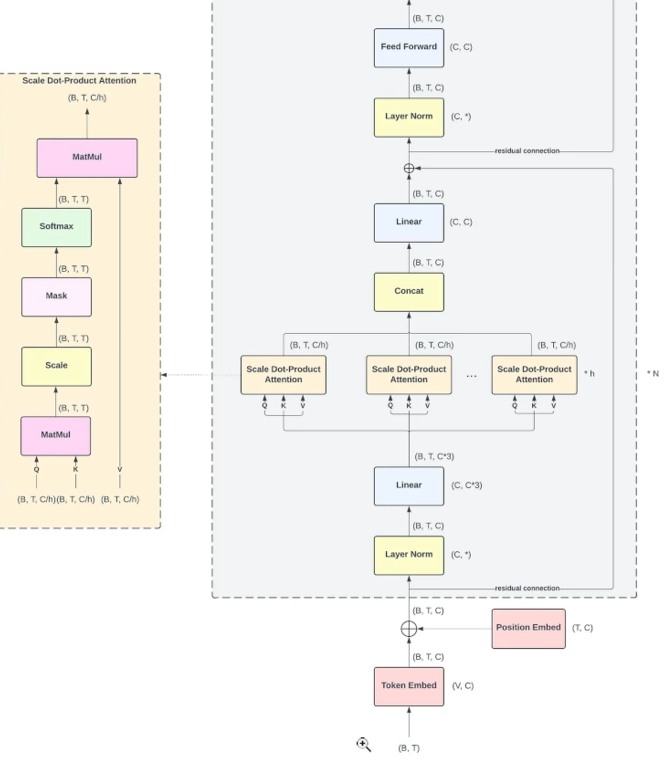
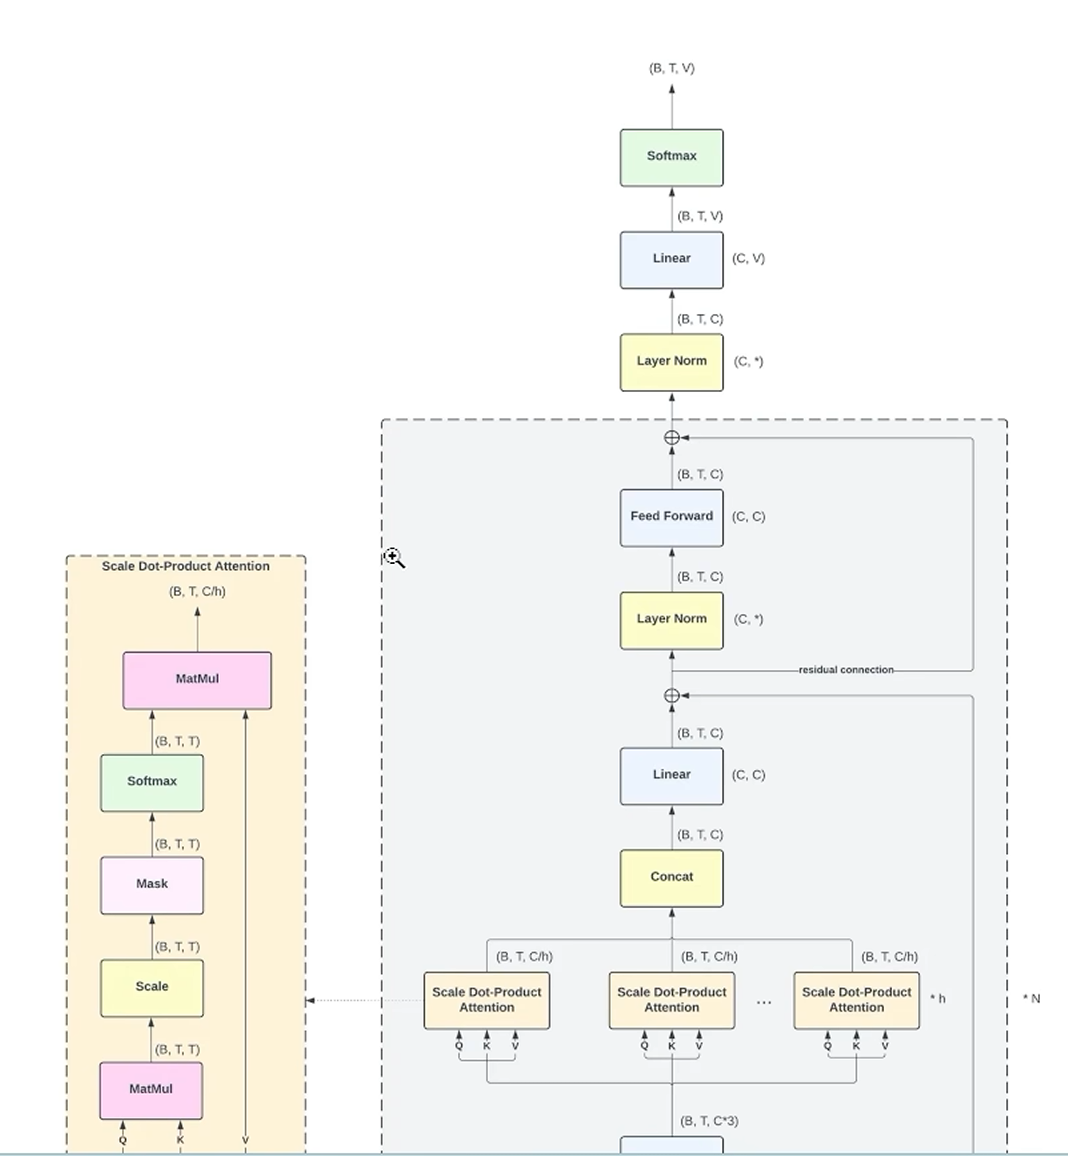

# 1 导入相关的包

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from dataclasses import dataclass
import math
torch.manual_seed(1024)

# 2 定义参数

In [16]:
@dataclass
class GPTConfig:
    block_size: int=512  # 这里其实应该是文本的最大长度（ max_seq_len）
    batch_size: int=12
    n_layer: int=12
    n_head: int=12
    n_embd: int=768 # n_embd 也叫 hidden_dim, hiden_size, 这里我同时设置了和 embed_dim 一样
    hidden_dim: int=768
    # 为了可以tie_embedding_weight
    dropout:float=0.1
    head_size: int =n_embd//n_head
    vocab_size: int =50257 # tiktoken 使用的是 GPT-2 的词表，大约有 50257 个token

In [14]:
a:int=3 # :int代表是一个int数字 是一个类似于注释的效果

In [15]:
a

3

# 3 定义GPT结构

## 3.1 单头注意力机制

In [44]:
class SingleHeadAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.key = nn.Linear(config.hidden_dim,config.head_size)
        self.value = nn.Linear(config.hidden_dim,config.head_size)
        self.query = nn.Linear(config.hidden_dim,config.head_size)
        # attention mask通过registerbuffer注册 不用计算梯度 节约内存和显存
        self.register_buffer(
            'attention_mask',
            torch.tril(
                torch.ones(config.block_size, config_block_size)
            )
        )
        self.dropout = nn.Dropout(config.dropout)
        self.head_size = config.head_size

    def forward(self,x):
        batch_size,seq_len,hidden_dim = x.size()
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        # weight b seq seq
        weight = q@k.transpose(-1,-2)/math.sqrt(self.head_size)
        weight = weight.masked_fill(
            self.attention_mask[:seq_len, :seq_len]==0, -torch.inf
        )
        weight = torch.softmax(weight,-1)
        weight = self.dropout(weight)
        output = weight@v
        return output

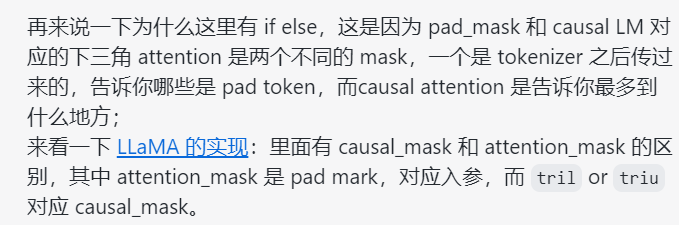
这里self.attention_mask[:seq_len, :seq_len]==0有seq_len是因为不一定是所有的512全部都用到了，有pad部分，需要mask掉。而casual mask是根据因果，一个个逐个得到，所以是一个下三角形的

https://bruceyuan.com/hands-on-code/hands-on-causallm-decoder.html#%E4%BA%A4%E4%B8%AA%E6%9C%8B%E5%8F%8B%F0%9F%A4%A3

# 3.2 多头注意力机制

In [20]:
class MultiHeadAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.heads = nn.ModuleList(
            [
                SingleHeadAttention(config)
                for _ in range(config.n_head)
            ]
        )
        self.proj = nn.Linear(config.hidden_dim,config.hidden_dim)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self,x):
        output = torch.cat(
            [h(x) for h in self.heads],
            dim=-1
        )
        output = self.proj(output)
        output = self.dropout(output)
        return output

## 3.3 ffn


In [21]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.hidden_dim,4*config.hidden_dim),
            nn.GELU(),
            nn.Linear(4*config.hidden_dim, config.hidden_dim),
            nn.Dropout(config.dropout)
        )

    def forward(self,x):
        # modulelist就需要一个个for循环输出 不会自动forward
        return self.net(x)


## 3.4 block

In [33]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.att = MultiHeadAttention(config)
        self.ffn = FeedForward(config)
        self.ln1 = nn.LayerNorm(config.hidden_dim)
        self.ln2 = nn.LayerNorm(config.hidden_dim)

    def forward(self, x):
        x = x + self.att(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

In [37]:
Block(GPTConfig)

Block(
  (att): MultiHeadAttention(
    (heads): ModuleList(
      (0-11): 12 x SingleHeadAttention(
        (key): Linear(in_features=768, out_features=64, bias=True)
      )
    )
    (proj): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ffn): FeedForward(
    (net): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=3072, out_features=768, bias=True)
      (3): Dropout(p=0.1, inplace=False)
    )
  )
  (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

## 3.5 GPT
position embedding从0 1 2 3.... 升级到rope

layernorm 升级到 rmsnorm

mlp 升级到 swiglu

mha升级到gqa

In [40]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embedding_table = nn.Embedding(config.vocab_size, config.n_embd)
        self.position_embedding_table = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.Sequential(
            *[Block(config) for _ in range(config.n_layer)]
        )
        self.ln_final = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size,bias=False)
        # 现在的SLM模型 会用tie weight减少参数
        # 减少参数量 降低内存消耗 加速收敛  输出的时候直接利用输入的嵌入语义 增加生成质量
        # linear 4->8 weight实际上shape是8*4
        self.token_embedding_table.weight = self.lm_head.weight
        def _init_weights(self, module):
            if isinstance(module, nn.Linear):
                torch.nn.init.normal_(module.weight,mean=0,std=0.02)
                if module.bias is not None:
                    torch.nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                torch.nn.init.normal_(module.weight,mean=0,std=0.02)
        def forward(self, idx,targets =None):
            # idx输入是token ids(batchsize, seq)
            # targets是目标token ids (batchsize, seq) 一般是idx输入向右移位的结果
            # shape要一样
            batch,seq_len = idx.size()
            token_emb = self.token_embedding_table(idx)
            pos_emb = self.position_embedding_table(torch.arange(seq_len,device=idx.device))
            # token embedding和position embedding为什么是可以相加的？
            x = token_emb + pos_emb
            x = self.blocks(x)
            x = self.ln_final(x)
            logits = self.lm_head(x)
            if targets is None:
                loss = None
            else:
                batch,seq_len,vocab_size = logits.size()
                logits = logits.view(batch*seq_len, vocab_size)
                targets = targets.view(batch*seq_len)
                loss = F.cross_entropy(logits, targets)
            return logits,loss
       def generate(self, idx, max_new_tokens):
            # idx is (B, T) array of indices in the current context
            for _ in range(max_new_tokens):
                # 如果序列太长，只取最后 block_size 个token
                idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
                # 获取预测
                logits, _ = self(idx_cond) # 调用的forward
                # 只关注最后一个时间步的预测
                logits = logits[:, -1, :]  # becomes (B, vocab_size) # 原本是B seq vocab_size
                # 应用softmax获取概率
                probs = F.softmax(logits, dim=-1)
                # 随机采样下一个token
                idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
                # 附加到序列上
                idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
            return idx
                
            
                

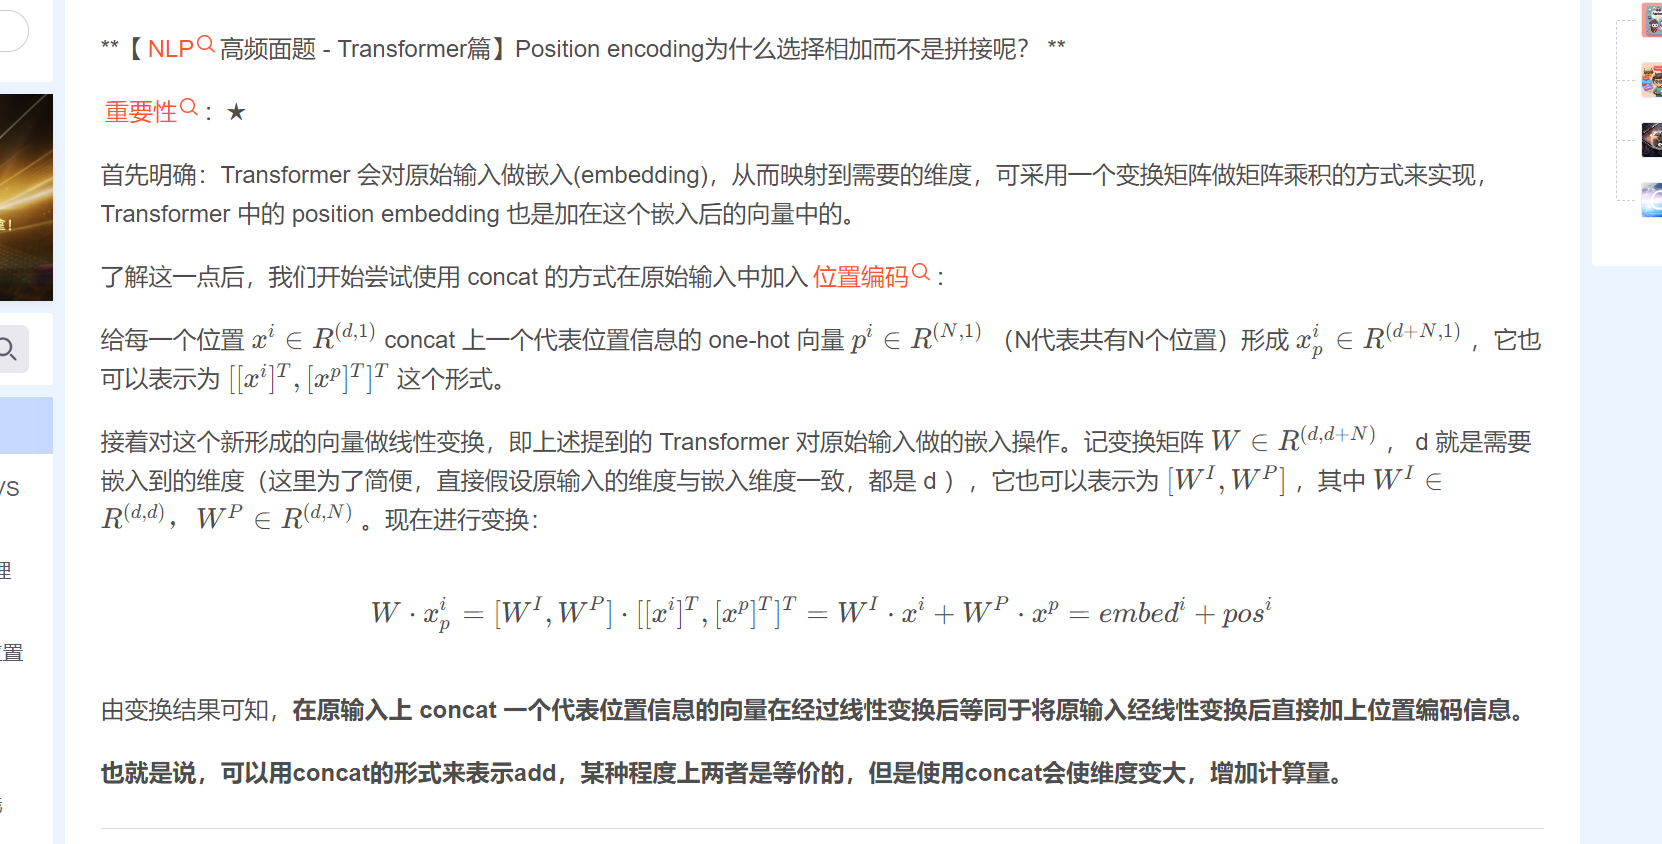

In [45]:
torch.arange(512).shape

torch.Size([512])

In [48]:
position_embedding_table = nn.Embedding(GPTConfig.block_size, GPTConfig.n_embd)
position_embedding_table

Embedding(512, 768)

In [63]:
a = position_embedding_table(torch.arange(512))
a.shape

torch.Size([333, 768])

In [58]:
b = position_embedding_table(torch.arange(512).unsqueeze(0).repeat(3,1))
b.shape

torch.Size([3, 512, 768])

In [60]:
c = a+b
c.shape  # 广播机制 所有batch都加上了    embedding只是增加一维度

torch.Size([3, 512, 768])

# 4 构建输入的DATASET

In [25]:
import tiktoken
import json

In [30]:
class MyDataset(Dataset):
    def __init__(self, path, block_size=512):
        self.enc = tiktoken.get_encoding('gpt2')
        self.block_size = block_size
        self.encoded_data = []
        # 特殊符号分割不同的训练文本
        # <|endoftext|>
        self.eos_token = self.enc.encode(
            '<|endoftext|>',
            allowed_special={'<|endoftext|>'}
        )[0]# [50256]
        self.max_lines = 1000
        raw_data = []
        with open(path,'r') as f:
            for i,line in enumerate(f):
                if i >= self.max_lines:
                    break
                try:
                    text = json.loads(line.strip())['text']
                    raw_data.append(text)
                except Exception as e:
                    continue
        full_encoded = []
        # 把所有文本换成一行
        for text in raw_data:
            encoded_text = self.enc.encode(text)
            full_encoded.extend(encoded_text + [self.eos_token])
        # block size是512
        # 长的要切割到512
        for i in range(0, len(full_encoded),self.block_size):
            chunk = full_encoded[i:i+self.block_size+1]# 因为还要往右边shift一位 每一行实际是513
            # 因为label实际上是要往右移动一位的
            if len(chunk) < self.block_size + 1:
                chunk = chunk + [self.eos_token] * (self.block_size+1-len(chunk)) # 后面用eos填补
            self.encoded_data.append(chunk)

    def __len__(self,):
        return len(self.encoded_data)

    def __getitem__(self, idx):
        chunk = self.encoded_data[idx]
        x = torch.tensor(chunk[:-1], dtype = torch.long)
        y = torch.tensor(chunk[1:],dtype=torch.long)
        return x,y

    def encode(self, text):
        return self.enc.encode(text)
    def decode(self,ids):
        return self.enc.decode(ids)
            
                    

In [27]:
ls = [1,2,3,4,5]

ls[2:8]# 直接到底 不会报错

[3, 4, 5]

In [66]:
ls.append([1,2]) # 拓展单个元素
ls

[1, 2, 3, 4, 5, [1, 2], [1, 2]]

In [67]:
ls.extend([1,2]) # 只能是列表元组字符串 拓展多个元素
ls


[1, 2, 3, 4, 5, [1, 2], [1, 2], 1, 2]

In [68]:
ls.extend(1)

TypeError: 'int' object is not iterable

In [31]:
# 数据的格式
"""
{"text":"担任地点省市的区域运营中心的办理作业。承受总部相关KPI查核。\n1、了解新闻职业或媒体相关运营运营岗位，其间，应聘区域运营中心主任有3年以上当地干流媒体作业经验者优先，应聘事务主管有2年以上当地干流媒体作业经验者优先。\n2、交流才能强，抗压才能强，长于处理复杂情况，了解GR作业优先，能独立完结策划计划优先。具有独立开发客户才能。\n北京、天津、河北、山西、黑龙江、吉林、辽宁、上海、江苏、浙江、安徽、江西、福建、山东、河南、湖北、湖南、广东、海南、重庆、四川、贵州、云南、陕西等。"}
"""

'\n{"text":"担任地点省市的区域运营中心的办理作业。承受总部相关KPI查核。\n1、了解新闻职业或媒体相关运营运营岗位，其间，应聘区域运营中心主任有3年以上当地干流媒体作业经验者优先，应聘事务主管有2年以上当地干流媒体作业经验者优先。\n2、交流才能强，抗压才能强，长于处理复杂情况，了解GR作业优先，能独立完结策划计划优先。具有独立开发客户才能。\n北京、天津、河北、山西、黑龙江、吉林、辽宁、上海、江苏、浙江、安徽、江西、福建、山东、河南、湖北、湖南、广东、海南、重庆、四川、贵州、云南、陕西等。"}\n'

# 运行


In [41]:
model = GPT(GPTConfig())
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# 打印模型一共有多少参数

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params / 1e6} M")

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
# 设置 cosine 学习率
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)


Total parameters: 109.872384 M


In [42]:
# seq monky数据集  10GB 太大了 没有下
# train data
train_dataset = MyDataset('/root/fs/mobvoi_seq_monkey_general_open_corpus.jsonl')

# split traindataset to train and val
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1])

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=False)



FileNotFoundError: [Errno 2] No such file or directory: '/root/fs/mobvoi_seq_monkey_general_open_corpus.jsonl'

In [43]:
# 训练循环
def train(model, optimizer, scheduler, train_loader, val_loader, device):
    model.train()
    total_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        # 将数据移到设备上
        x, y = x.to(device), y.to(device)
        
        # 前向传播
        logits, loss = model(x, targets=y)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 调整学习率
        scheduler.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
    return total_loss

def eval(model, val_loader, device):
    # 验证
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits, loss = model(x, targets=y)
            val_loss += loss.item()
    return val_loss


for epoch in range(2):
    train_loss = train(model, optimizer, scheduler, train_loader, val_loader, device)
    val_loss = eval(model, val_loader, device)
    print(f'Epoch: {epoch}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

    # 保存模型
    avg_val_loss = val_loss / len(val_loader)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'val_loss': avg_val_loss,
    }
    # 保存每个epoch的模型
    torch.save(checkpoint, f'checkpoints/model_epoch_{epoch}.pt')
    

NameError: name 'train_loader' is not defined